In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import visionloader as vl
import os
import src.fitting as fitting
import src.multielec_utils as mutils
import src.old_labview_data_reader as oldlv
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cp
from scipy.optimize import minimize
import statsmodels.api as sm
import operator as op
import itertools as it
import GPy

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
# Current values in uA

Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [3]:
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = "/Volumes/Scratch/Users/praful/newlv_gsort_v2_30um_periphery"
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_periphery-affinity_cosine"

In [27]:
dataset = "2020-10-06-7"
estim = "data003/data003-all"
estim_1elec = "data001"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [28]:
wnoise = "kilosort_data000/data000"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [29]:
def all_combos(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    powerset = list(it.chain.from_iterable(it.combinations(s, r) for r in range(1, len(s)+1)))
    
    targets = []
    nontargets = []
    for i in powerset:
        for j in powerset:
            if len(np.intersect1d(np.array(i), np.array(j))) == 0:
                targets.append(np.array(i))
                nontargets.append(np.array(j))
                
    return np.array(targets, dtype=object), np.array(nontargets, dtype=object)

In [30]:
def classifySelectivity(targets, nontargets):
    target_types = np.zeros(len(targets), dtype=bool)
    for i in range(len(targets)):
        t = targets[i]
        cell_type = vcd.get_cell_type_for_cell(t).lower()
        if 'on' in cell_type:
            target_types[i] = True

    nt_types = np.zeros(len(nontargets), dtype=bool)
    for i in range(len(nontargets)):
        nt = nontargets[i]
        cell_type = vcd.get_cell_type_for_cell(nt).lower()
        if 'on' in cell_type:
            nt_types[i] = True

    if (np.all(target_types) and ~np.any(nt_types)) or (~np.any(target_types) and np.all(nt_types)):
        classification = 'ON/OFF'

    elif np.all(target_types) and np.all(nt_types):
        classification = 'ON/ON'

    elif ~np.any(target_types) and ~np.any(nt_types):
        classification = 'OFF/OFF'

    else:
        classification = 'mixed'
        
    return classification

In [31]:
def get1elecSelectivity(dataset, multipath, gsort_path_1elec, estim_1elec, wnoise, p, targets, nontargets, spont_limit=0.2, noise_limit=0.1, show_plots=False):
    multi_elecs = mutils.get_stim_elecs_newlv(multipath, p)
    curr_cells = np.sort(np.concatenate((targets, nontargets)))
    
    all_signals = []
    target_sigmoids = []
    nt_sigmoids = []
    
    for elec in multi_elecs:
        filepath_1elec = os.path.join(gsort_path_1elec, dataset, estim_1elec, wnoise, "p" + str(elec))
        if show_plots:
            plt.figure()
            plt.title(str(elec))
            plt.ylim(-0.1, 1.1)
            plt.ylabel('Activation Probability')
            plt.xlabel('Current Amplitude (uA)')

        target_sigmoids_elec = []
        nt_sigmoids_elec = []

        cell_signals = []
        for cell in curr_cells:
            k = 0
            probs = []
            trials = []
            signals = []
            while True:
                try:
                    with open(os.path.join(filepath_1elec, "gsort_single_v2_n" + str(cell) + "_p" + str(elec) + "_k" + str(k) + ".pkl"), "rb") as f:
                        prob_dict = pickle.load(f)
                        probs.append(prob_dict["cosine_prob"][0])
                        trials.append(prob_dict["num_trials"])
                        electrode_list = prob_dict["electrode_list"]

                    signal = oldlv.get_oldlabview_pp_data(os.path.join(ANALYSIS_BASE, dataset, estim_1elec), 
                                                          elec, k)[:,electrode_list,:55]
                    signals.append(signal)
                except:
                    break

                k += 1

            cell_signals.append(signals)
            trials = np.array(trials, dtype=int)
            probs = np.array(probs)

            if len(probs) > 0:    
                probs = fitting.disambiguate_sigmoid(probs, spont_limit=spont_limit, noise_limit=noise_limit)

                X_bin, y_bin = fitting.convertToBinaryClassifier(probs, trials, Ivals[:k].reshape(-1, 1))

                results = minimize(fitting.negLL, x0=np.array([-1, 1]), args=(X_bin, y_bin, False, 'none'))

                currs = np.linspace(0.1, 4.5, 100)
                sigmoid = fitting.fsigmoid(sm.add_constant(currs.reshape(-1, 1)), results.x)
                if cell in targets:
                    target_sigmoids_elec.append(sigmoid)
                else:
                    nt_sigmoids_elec.append(sigmoid)

                if show_plots:
                    plt.plot(currs, sigmoid)
                    plt.scatter(Ivals[:k], probs, alpha=0.5, 
                                label=vcd.get_cell_type_for_cell(cell) + ' ' + str(cell))

        if show_plots:
            plt.legend()
            plt.show()

        all_signals.append(cell_signals)
        target_sigmoids.append(np.array(target_sigmoids_elec))
        nt_sigmoids.append(np.array(nt_sigmoids_elec))
    
    selec_vals_1elec = np.zeros(len(multi_elecs))
    for i in range(len(multi_elecs)):
        selec_vals_1elec[i] = np.amax(np.multiply.reduce(target_sigmoids[i], axis=0) * 
                                      (1 - np.amax(nt_sigmoids[i], axis=0)))
        
    best_1elec = np.amax(selec_vals_1elec)
    
    return best_1elec

In [32]:
def fitMultielecSurface(multipath, gsort_multipath, dataset, estim, wnoise, p,
                        cells, downsample=False, downsample_trials=10, downsample_factor=2, 
                        load_from_mat=True, show_plots=False, verbose=False):
    
    all_amps = mutils.get_stim_amps_newlv(multipath, p)
    means_all = []
    vars_all = []
    X_amps = []
    X_probs = []
    
    for cell in cells:
        X, probs, T = mutils.loadNewLVData(multipath, gsort_multipath, dataset, estim, wnoise, p, cell,
                                       downsample=downsample, downsample_trials=downsample_trials, 
                                       downsample_factor=downsample_factor,load_from_mat=load_from_mat, 
                                       MATFILE_BASE=MATFILE_BASE)
        
        
        X_amps.append(X)
        X_probs.append(probs)
        y = np.log(probs / (1 - probs))
        
        # Best parameters found so far
        k_R = GPy.kern.RBF(input_dim=all_amps.shape[-1], variance=3, lengthscale=4, name="RBF")
        k_M = GPy.kern.Matern32(input_dim=all_amps.shape[-1], variance=2., lengthscale=1, name="Matern32")
#         kernel = GPy.kern.RBF(input_dim=all_amps.shape[-1], variance=variance, lengthscale=lengthscale)
        kernel = k_R * k_M
        m = GPy.models.GPRegression(X, y.reshape(-1, 1), kernel, noise_var=1)

        mean, var = m.predict_noiseless(X)
        mean_all, var_all = m.predict_noiseless(all_amps)
        means_all.append(mean_all.flatten())
        vars_all.append(var_all.flatten())
        
        if show_plots:
            fig = plt.figure()
            fig.clear()
            ax = Axes3D(fig)
            plt.xlabel(r'$I_1$')
            plt.ylabel(r'$I_2$')
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$')

            scat = ax.scatter(all_amps[:, 0], 
                        all_amps[:, 1],
                        all_amps[:, 2], marker='o', s=20, c=1 / (1 + np.exp(-mean_all.flatten())), alpha=0.8)


            clb = plt.colorbar(scat)
            plt.show()

            fig = plt.figure()
            fig.clear()
            ax = Axes3D(fig)
            plt.xlabel(r'$I_1$')
            plt.ylabel(r'$I_2$')
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$')

            scat = ax.scatter(all_amps[:, 0], 
                        all_amps[:, 1],
                        all_amps[:, 2], marker='o', s=20, c=var_all.flatten(), alpha=0.8)


            clb = plt.colorbar(scat)
            plt.show()

            plt.figure()
            plt.scatter(probs, 1 / (1 + np.exp(-mean.flatten())))

            fig = plt.figure()
            fig.clear()
            ax = Axes3D(fig)
            ax = Axes3D(fig)
            plt.xlabel(r'$I_1$')
            plt.ylabel(r'$I_2$')
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$')

            scat = ax.scatter(X[:, 0], 
                        X[:, 1],
                        X[:, 2], marker='o', s=20, c=1 / (1 + np.exp(-mean)), alpha=0.8)


            clb = plt.colorbar(scat)
            plt.show()

            fig = plt.figure()
            fig.clear()
            ax = Axes3D(fig)
            ax = Axes3D(fig)
            plt.xlabel(r'$I_1$')
            plt.ylabel(r'$I_2$')
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$')

            scat = ax.scatter(X[:, 0], 
                        X[:, 1],
                        X[:, 2], marker='o', s=20, c=probs, alpha=0.8)


            clb = plt.colorbar(scat)
            plt.show()
    
    return all_amps, np.array(means_all), np.array(vars_all), X_amps, X_probs

In [35]:
p = 1
all_cells = np.array([84, 244], dtype=int)

all_targets, all_nontargets = all_combos(all_cells)
selec_comparison = []

1
[244] [84] ON/ON


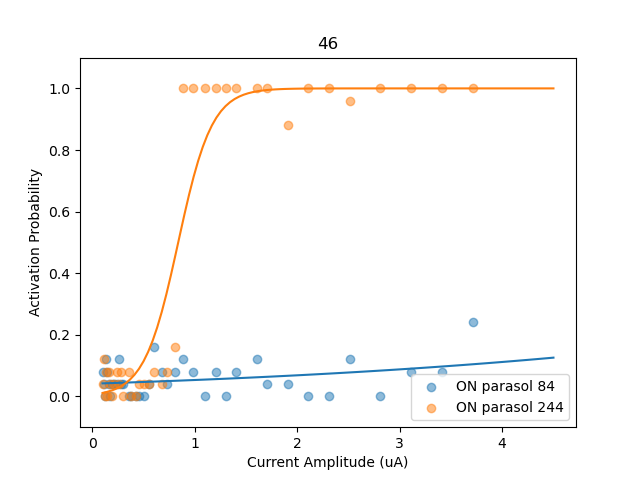

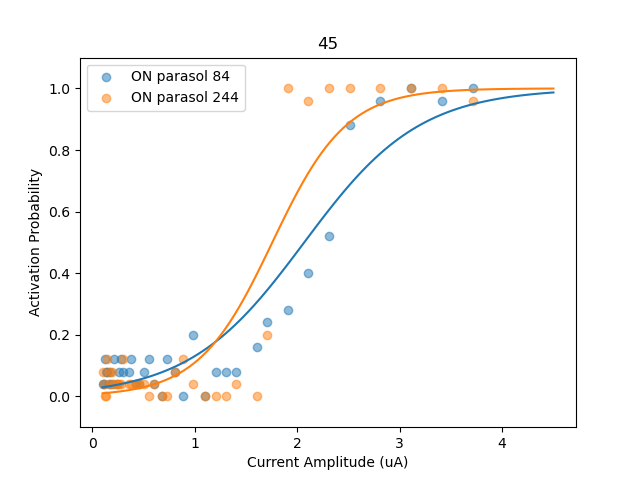

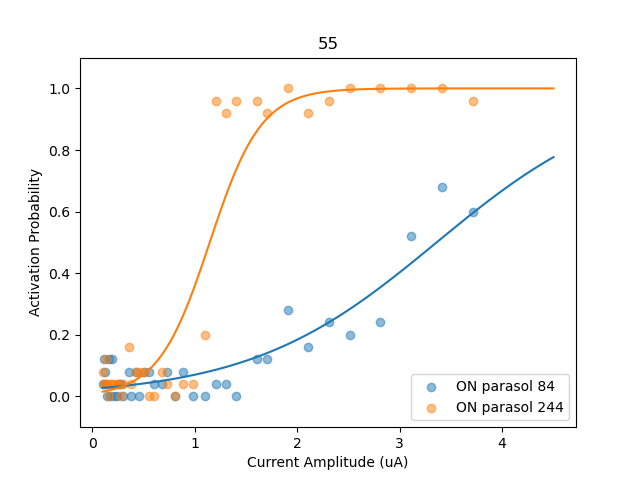

0.9320600417710206


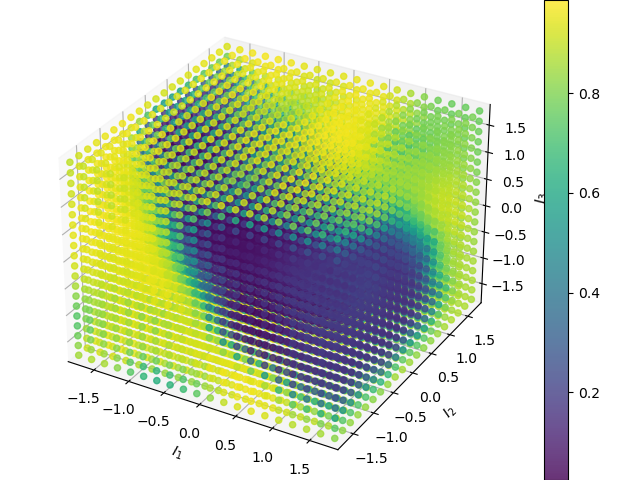

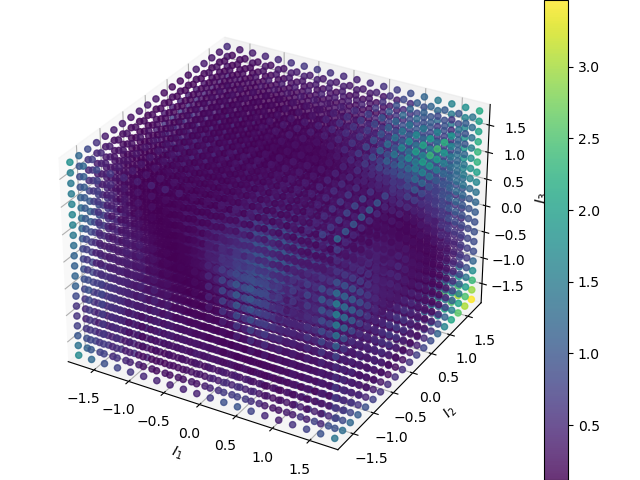

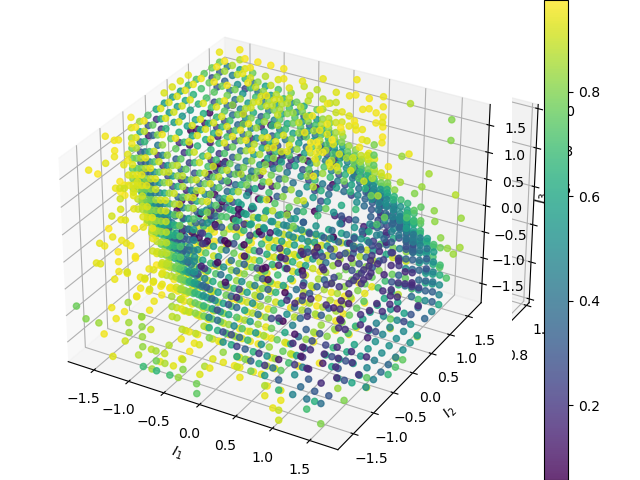

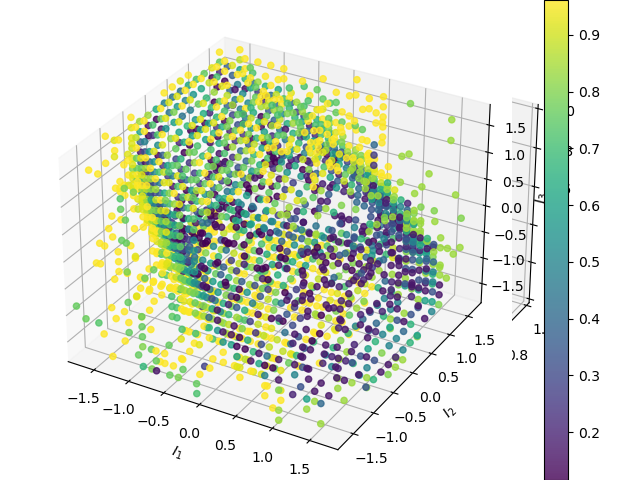

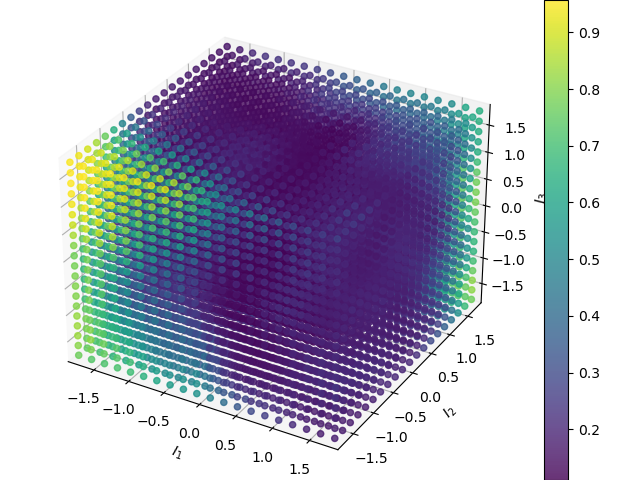

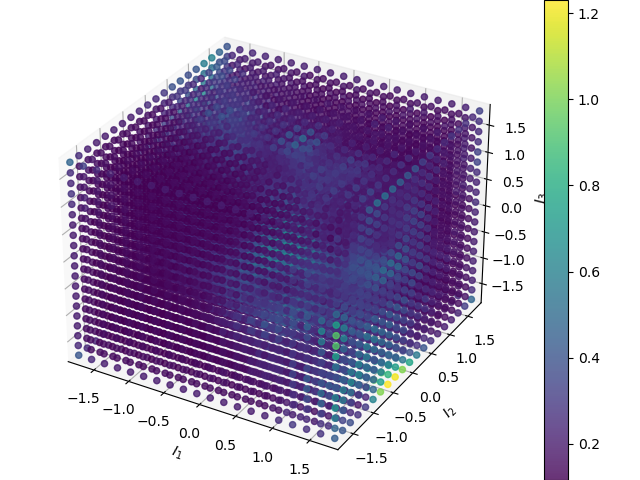

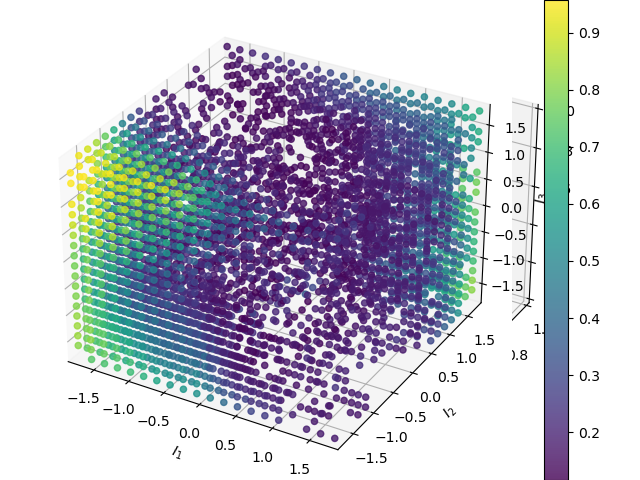

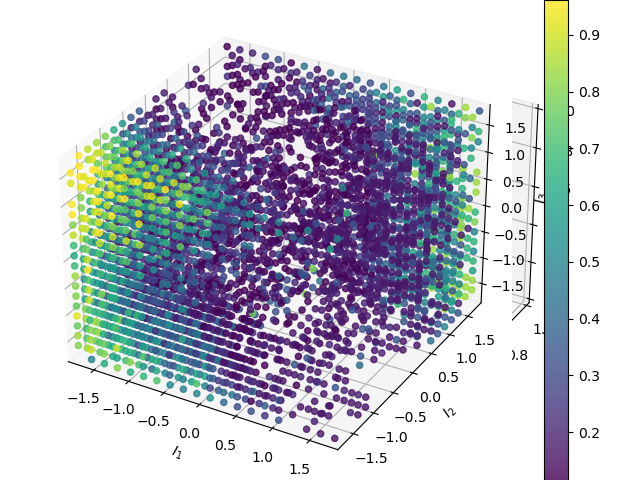

0.8609289534317459


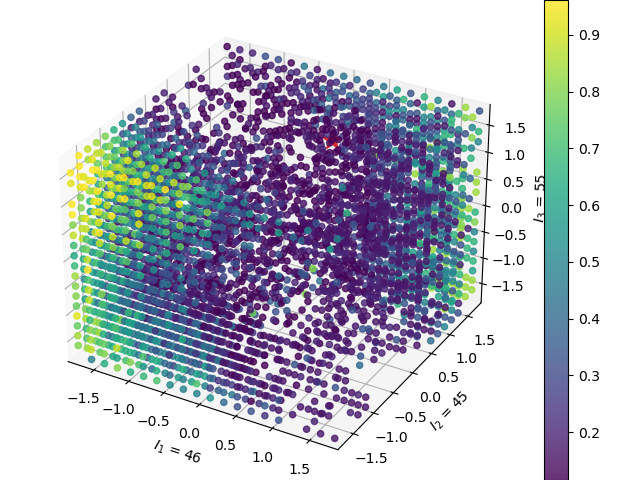

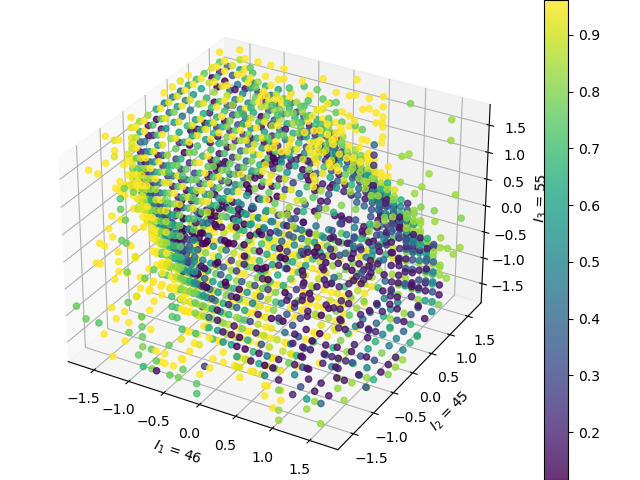

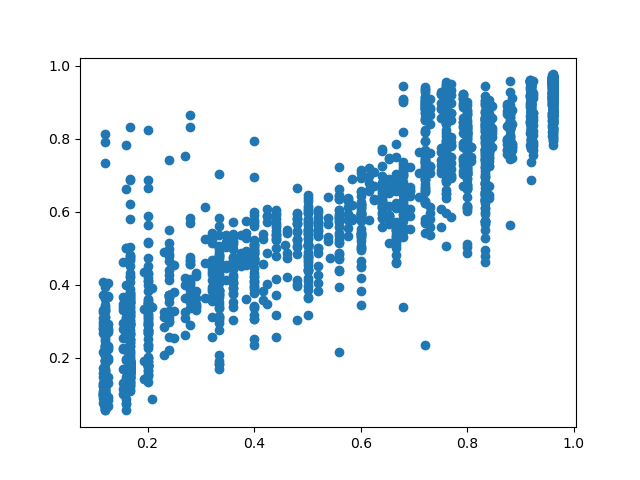

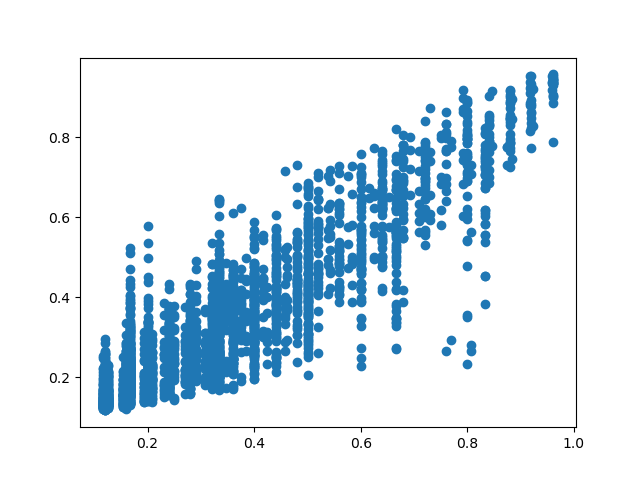

In [37]:
Imax = 1.8
debug = True
for m in range(len(all_targets)):
    if debug:
        m = 1
    print(m)
    targets = all_targets[m]
    nontargets = all_nontargets[m]

    classification = classifySelectivity(targets, nontargets)
    print(targets, nontargets, classification)
    
    best_1elec = get1elecSelectivity(dataset, electrical_path, gsort_path_1elec, estim_1elec, 
                                     wnoise, p, targets, nontargets, spont_limit=0.15, noise_limit=0.15, show_plots=debug)
    
    print(best_1elec)
    
    amps, t_means, t_vars, t_amps, t_probs = fitMultielecSurface(electrical_path, gsort_path, 
                                                                 dataset, estim, wnoise, p, targets,
                                                                 downsample=False, downsample_trials=20, show_plots=debug)
    amps, nt_means, nt_vars, nt_amps, nt_probs = fitMultielecSurface(electrical_path, gsort_path, 
                                                                     dataset, estim, wnoise, p, nontargets,
                                                                     downsample=False, downsample_trials=20, show_plots=debug)
    
    t_preds = 1 / (1 + np.exp(-t_means))
    nt_preds = 1 / (1 + np.exp(-nt_means))
    
    selec_vals = np.multiply.reduce(t_preds, axis=0) * (1 - np.amax(nt_preds, axis=0))
    selec_vec = amps[np.argmax(selec_vals)]
    best_multielec = np.amax(selec_vals)
    
    selec_comparison.append((best_1elec, best_multielec, classification))
    
    print(best_multielec)
    
    multi_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
    for i in range(len(nt_amps)):
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig)
        plt.xlabel(r'$I_1$ = ' + str(multi_elecs[0]))
        plt.ylabel(r'$I_2$ = ' + str(multi_elecs[1]))
        plt.xlim(-Imax, Imax)
        plt.ylim(-Imax, Imax)
        ax.set_zlim(-Imax, Imax)
        ax.set_zlabel(r'$I_3$ = ' + str(multi_elecs[2]))

        scat = ax.scatter(nt_amps[i][:, 0], 
                    nt_amps[i][:, 1],
                    nt_amps[i][:, 2], marker='o', s=20, c=nt_probs[i], alpha=0.8)

        ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=200)

        clb = plt.colorbar(scat)
        plt.show()
        
    for i in range(len(t_amps)):
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig)
        plt.xlabel(r'$I_1$ = ' + str(multi_elecs[0]))
        plt.ylabel(r'$I_2$ = ' + str(multi_elecs[1]))
        plt.xlim(-Imax, Imax)
        plt.ylim(-Imax, Imax)
        ax.set_zlim(-Imax, Imax)
        ax.set_zlabel(r'$I_3$ = ' + str(multi_elecs[2]))

        scat = ax.scatter(t_amps[i][:, 0], 
                    t_amps[i][:, 1],
                    t_amps[i][:, 2], marker='o', s=20, c=t_probs[i], alpha=0.8)

        ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=200)

        clb = plt.colorbar(scat)
        plt.show()
    
    if debug:
        break

In [25]:
selec_comparison

[(1.1487172333703354e-08, 0.8431716442942668, 'ON/ON'),
 (0.3070515401044719, 0.8799210942789388, 'ON/OFF'),
 (1.1486312624832923e-08, 0.8041187282233725, 'mixed'),
 (1.0, 0.9904463103130177, 'ON/ON'),
 (0.9860970850965591, 0.9214866616928581, 'ON/OFF'),
 (0.9860970850965591, 0.9130757817767503, 'mixed'),
 (0.999999995893208, 0.9877735834836061, 'ON/OFF'),
 (0.9999367587387943, 0.9437226759364643, 'ON/OFF'),
 (0.9999367587387943, 0.9437226759364643, 'ON/OFF'),
 (0.3070515401044719, 0.8732110703607623, 'ON/OFF'),
 (8.06688028818116e-09, 0.6792844315231137, 'mixed'),
 (0.999999995893208, 0.9796922309011699, 'mixed')]

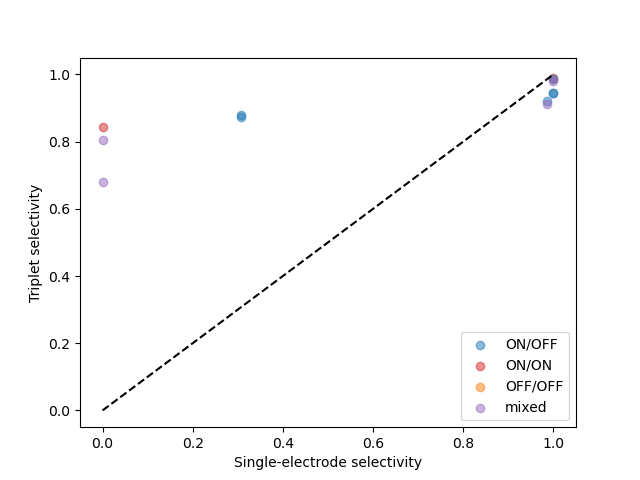

In [26]:
plt.figure()
for i in range(len(selec_comparison)):
    if selec_comparison[i][2] == 'ON/OFF':
        color = 'tab:blue'
    if selec_comparison[i][2] == 'ON/ON':
        color = 'tab:red'
    if selec_comparison[i][2] == 'OFF/OFF':
        color = 'tab:orange'
    if selec_comparison[i][2] == 'mixed':
        color = 'tab:purple'
    plt.scatter(np.array(selec_comparison)[i, 0].astype(float), 
                np.array(selec_comparison)[i, 1].astype(float), alpha=0.5, c=color)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='--', c='k')
plt.xlabel('Single-electrode selectivity')
plt.ylabel('Triplet selectivity')
leg = plt.legend(['ON/OFF', 'ON/ON', 'OFF/OFF', 'mixed'])
leg.legendHandles[0].set_color('tab:blue')
leg.legendHandles[1].set_color('tab:red')
leg.legendHandles[2].set_color('tab:orange')
leg.legendHandles[3].set_color('tab:purple')